# tax2tree

## Background

[**tax2tree**](https://github.com/wasade/tax2tree) ([McDonald et al., 2012](https://www.nature.com/articles/ismej2011139)) automatically curates taxonomic annotations of tree tips and internal nodes based on tree topology.

## Preparation

### Dependencies

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from skbio import TreeNode

### Installation

In [ ]:
%%bash
conda create -n tax2tree numpy Click future==0.13.1 scikit-bio==0.2.3 python=2
source activate tax2tree
pip install git+https://github.com/wasade/tax2tree.git

### Input files

 - A tree in Newick format.
 - A mapping file defining taxon names at the seven ranks:

In [99]:
!head -n5 ../ncbi/ranks.gg.tsv

G000003135	k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Bifidobacteriales; f__Bifidobacteriaceae; g__Bifidobacterium; s__Bifidobacterium longum
G000003215	k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptostreptococcaceae; g__Clostridioides; s__Clostridioides difficile
G000003645	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus cereus
G000003925	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus mycoides
G000003955	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus cereus


## Analyses

### Run tax2tree

Decorate the ASTRAL tree with taxdump.

In [51]:
%%script false
!t2t decorate -t astral.MR.rooted.tre -m ranks.gg.tsv -o astral.MR.rooted.taxdump.consistency.txt

Assess the consistency between taxdump and topology.

In [52]:
%%script false
!t2t consistency -t astral.MR.rooted.tre -m ranks.gg.tsv -o astral.MR.rooted.taxdump.consistency.txt

### Analyze consistency

In [92]:
df = pd.read_table('astral.MR.rooted.taxdump.consistency.txt')
df.head()

,Taxon,Count,Consistency
0,k__Archaea,652,1.0
1,k__Bacteria,9575,1.0
2,p__Candidatus Adlerbacteria,5,1.0
3,p__Thermotogae,35,1.0
4,p__Candidatus Doudnabacteria,19,1.0


In [93]:
df['Name'] = df['Taxon'].str.split('__').str.get(1)
df['Rank'] = df['Taxon'].str.split('__').str.get(0).map(code2rank)
df.set_index('Taxon', inplace=True)
df.head()

,Count,Consistency,Name,Rank
Taxon,,,,
k__Archaea,652,1.0,Archaea,kingdom
k__Bacteria,9575,1.0,Bacteria,kingdom
p__Candidatus Adlerbacteria,5,1.0,Candidatus Adlerbacteria,phylum
p__Thermotogae,35,1.0,Thermotogae,phylum
p__Candidatus Doudnabacteria,19,1.0,Candidatus Doudnabacteria,phylum


In [94]:
df.head()

,Count,Consistency,Name,Rank
Taxon,,,,
k__Archaea,652,1.0,Archaea,kingdom
k__Bacteria,9575,1.0,Bacteria,kingdom
p__Candidatus Adlerbacteria,5,1.0,Candidatus Adlerbacteria,phylum
p__Thermotogae,35,1.0,Thermotogae,phylum
p__Candidatus Doudnabacteria,19,1.0,Candidatus Doudnabacteria,phylum


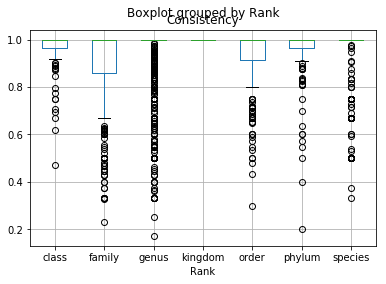

In [95]:
df.boxplot(column='Consistency', by='Rank');

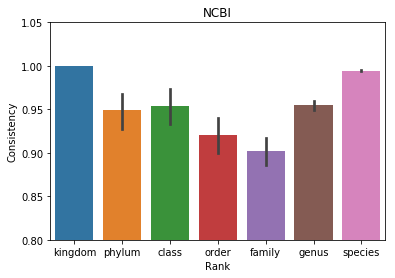

In [96]:
ax = sns.barplot(x='Rank', y='Consistency', data=df)
ax.set_ylim(0.8,)
ax.set_title('NCBI');

In [97]:
plt = ax.get_figure()
plt.tight_layout()
plt.savefig('NCBI.pdf', bbox_to_inches='tight')

### Analyze node decoration

Match decorations and node IDs.

In [5]:
tree_nid = TreeNode.read('../../ToLs/astral.MR.rooted.nid.tre')
tree_nid.count(tips=True)

10575

In [6]:
tree_t2t = TreeNode.read('astral.MR.rooted.taxdump.t2t.nwk')
tree_t2t.count(tips=True)

10575

Confirm that the decorated tree has the same topology and order of taxa as the original tree.

In [7]:
tree_nid.compare_rfd(tree_t2t)

0.0

In [10]:
nids = []
for node in tree_nid.levelorder():
    if not node.is_tip():
        nids.append(node.name)

In [11]:
decos = []
for node in tree_t2t.levelorder():
    if not node.is_tip():
        decos.append(node.name)

In [16]:
decos[:5]

[None, '1.0:k__Archaea', '0.75:k__Bacteria', '1.0', '0.7']

Generate a rank name table.

In [27]:
codes = ['k', 'p', 'c', 'o', 'f', 'g', 's']
ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [28]:
code2rank = {codes[i]: ranks[i] for i in range(len(codes))}

In [29]:
node2ranks = {}

In [41]:
for i in range(len(nids)):
    nid = nids[i]
    deco = decos[i]
    node2ranks[nid] = {x: '' for x in ranks}
    if deco is not None and '__' in deco:
        for taxon in deco.split(':')[-1].split('; '):
            code, name = taxon.split('__')
            node2ranks[nid][code2rank[code]] = name

In [50]:
df = pd.DataFrame.from_dict(node2ranks, orient='index')
df = df.loc[sorted(node2ranks, key=lambda x: int(x[1:]))]
df.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,,,,,,,
N5,,,,,,,


In [54]:
df.to_csv('nodes.ranks.tsv', sep='\t')